# Binance 资金费率与基差研究

本 Notebook 用于研究 Binance 永续合约的资金费率与基差之间的关系。

## 研究目标
1. 获取历史资金费率数据
2. 计算实时基差（现货价格 vs 永续合约价格）
3. 分析资金费率与基差的相关性
4. 可视化分析结果

## 1. 导入依赖

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ccxt
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('依赖导入成功！')

/Users/regan/work/go/src/github.com/stock-vip/binance-rate/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


依赖导入成功！


## 2. 初始化 Binance 交易所连接

In [3]:
# 初始化 Binance 现货和合约交易所
# 注意：只读取公开数据不需要 API Key

exchange_spot = ccxt.binance({
    'enableRateLimit': True,
    'options': {
        'defaultType': 'spot'
    }
})

exchange_futures = ccxt.binance({
    'enableRateLimit': True,
    'options': {
        'defaultType': 'swap',  # 永续合约
    }
})

print('交易所连接初始化成功！')
print(f'现货市场数量: {len(exchange_spot.load_markets())}')
print(f'合约市场数量: {len(exchange_futures.load_markets())}')

交易所连接初始化成功！
现货市场数量: 4128
合约市场数量: 4128


## 3. 核心函数定义

In [4]:
def get_funding_rate_history(symbol: str, days: int = 30) -> pd.DataFrame:
    """
    获取指定交易对的历史资金费率
    
    Args:
        symbol: 交易对，如 'BTC/USDT:USDT'
        days: 获取天数
    
    Returns:
        DataFrame 包含时间戳和资金费率
    """
    since = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)
    
    funding_rates = []
    while True:
        rates = exchange_futures.fetch_funding_rate_history(symbol, since=since, limit=1000)
        if not rates:
            break
        funding_rates.extend(rates)
        since = rates[-1]['timestamp'] + 1
        if len(rates) < 1000:
            break
    
    df = pd.DataFrame(funding_rates)
    if not df.empty:
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
        df = df.set_index('datetime')
        df['funding_rate_annualized'] = df['fundingRate'] * 3 * 365 * 100  # 年化百分比
    
    return df


def get_spot_price(symbol: str) -> float:
    """获取现货价格"""
    ticker = exchange_spot.fetch_ticker(symbol.replace(':USDT', ''))
    return ticker['last']


def get_futures_price(symbol: str) -> float:
    """获取永续合约价格"""
    ticker = exchange_futures.fetch_ticker(symbol)
    return ticker['last']


def calculate_basis(spot_price: float, futures_price: float) -> dict:
    """
    计算基差
    
    Returns:
        dict: 包含绝对基差和基差率（百分比）
    """
    basis = futures_price - spot_price
    basis_rate = (basis / spot_price) * 100
    
    return {
        'spot_price': spot_price,
        'futures_price': futures_price,
        'basis': basis,
        'basis_rate': basis_rate,  # 百分比
        'basis_annualized': basis_rate * 365 / 8 * 3  # 假设8小时一次资金费率，年化
    }


def get_current_funding_info(symbol: str) -> dict:
    """
    获取当前资金费率和基差的完整信息
    """
    # 获取资金费率
    funding = exchange_futures.fetch_funding_rate(symbol)
    
    # 获取价格
    spot_price = get_spot_price(symbol)
    futures_price = get_futures_price(symbol)
    
    # 计算基差
    basis_info = calculate_basis(spot_price, futures_price)
    
    return {
        'symbol': symbol,
        'funding_rate': funding['fundingRate'] * 100,  # 百分比
        'funding_rate_annualized': funding['fundingRate'] * 3 * 365 * 100,  # 年化百分比
        'next_funding_time': datetime.fromtimestamp(funding['fundingTimestamp'] / 1000),
        **basis_info
    }


print('核心函数定义完成！')

核心函数定义完成！


## 4. 获取实时数据

In [5]:
# 研究的主要交易对
symbols = [
    'BTC/USDT:USDT',
    'ETH/USDT:USDT',
    'SOL/USDT:USDT',
    'BNB/USDT:USDT',
    'XRP/USDT:USDT',
]

# 获取所有交易对的当前信息
current_data = []
for symbol in symbols:
    try:
        info = get_current_funding_info(symbol)
        current_data.append(info)
        print(f"✅ {symbol}: 资金费率={info['funding_rate']:.4f}%, 基差率={info['basis_rate']:.4f}%")
    except Exception as e:
        print(f"❌ {symbol}: {e}")

df_current = pd.DataFrame(current_data)
df_current

✅ BTC/USDT:USDT: 资金费率=0.0032%, 基差率=-0.0450%
✅ ETH/USDT:USDT: 资金费率=0.0067%, 基差率=-0.0503%
✅ SOL/USDT:USDT: 资金费率=0.0100%, 基差率=-0.0509%
✅ BNB/USDT:USDT: 资金费率=0.0037%, 基差率=0.0718%
✅ XRP/USDT:USDT: 资金费率=0.0100%, 基差率=-0.0431%


,symbol,funding_rate,funding_rate_annualized,next_funding_time,spot_price,futures_price,basis,basis_rate,basis_annualized
0,BTC/USDT:USDT,0.003152,3.45144,2025-12-09,91836.5500,91795.2000,-41.3500,-0.045026,-6.162885
1,ETH/USDT:USDT,0.006692,7.32774,2025-12-09,3138.1500,3136.5700,-1.5800,-0.050348,-6.891401
2,SOL/USDT:USDT,0.010000,10.95000,2025-12-09,137.5000,137.4300,-0.0700,-0.050909,-6.968182
3,BNB/USDT:USDT,0.003730,4.08435,2025-12-09,905.3200,905.9700,0.6500,0.071798,9.827326
4,XRP/USDT:USDT,0.010000,10.95000,2025-12-09,2.0894,2.0885,-0.0009,-0.043075,-5.895831


## 5. 获取历史资金费率数据

In [13]:
# 以 BTC 为例获取历史数据
symbol = 'BTC/USDT:USDT'
days = 300  # 获取90天数据

print(f'正在获取 {symbol} 最近 {days} 天的资金费率数据...')
df_funding = get_funding_rate_history(symbol, days=days)
print(f'获取到 {len(df_funding)} 条记录')
df_funding.head(10)

正在获取 BTC/USDT:USDT 最近 300 天的资金费率数据...
获取到 900 条记录


,info,symbol,fundingRate,timestamp,funding_rate_annualized
datetime,,,,,
2025-02-11 16:00:00.000,"{'symbol': 'BTCUSDT', 'fundingTime': '17392896...",BTC/USDT:USDT,-0.000024,1739289600000,-2.678370
2025-02-12 00:00:00.000,"{'symbol': 'BTCUSDT', 'fundingTime': '17393184...",BTC/USDT:USDT,0.000013,1739318400000,1.421310
2025-02-12 08:00:00.000,"{'symbol': 'BTCUSDT', 'fundingTime': '17393472...",BTC/USDT:USDT,0.000049,1739347200000,5.364405
2025-02-12 16:00:00.001,"{'symbol': 'BTCUSDT', 'fundingTime': '17393760...",BTC/USDT:USDT,0.000050,1739376000001,5.431200
2025-02-13 00:00:00.001,"{'symbol': 'BTCUSDT', 'fundingTime': '17394048...",BTC/USDT:USDT,0.000100,1739404800001,10.950000
2025-02-13 08:00:00.000,"{'symbol': 'BTCUSDT', 'fundingTime': '17394336...",BTC/USDT:USDT,0.000041,1739433600000,4.508115
2025-02-13 16:00:00.001,"{'symbol': 'BTCUSDT', 'fundingTime': '17394624...",BTC/USDT:USDT,0.000008,1739462400001,0.881475
2025-02-14 00:00:00.000,"{'symbol': 'BTCUSDT', 'fundingTime': '17394912...",BTC/USDT:USDT,0.000041,1739491200000,4.489500
2025-02-14 08:00:00.001,"{'symbol': 'BTCUSDT', 'fundingTime': '17395200...",BTC/USDT:USDT,0.000055,1739520000001,6.033450


## 6. 资金费率可视化

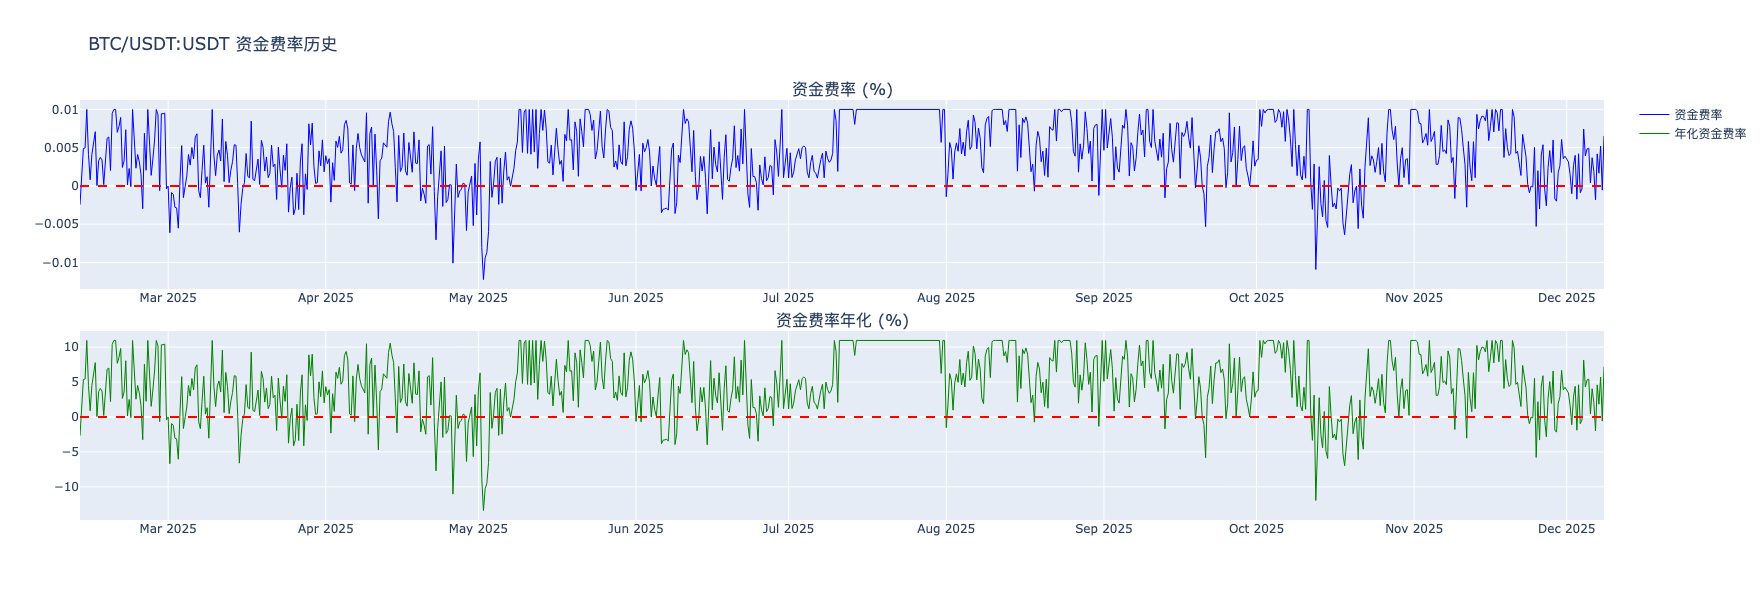

In [14]:
# 资金费率时序图
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('资金费率 (%)', '资金费率年化 (%)'),
    vertical_spacing=0.1
)

# 原始资金费率
fig.add_trace(
    go.Scatter(
        x=df_funding.index,
        y=df_funding['fundingRate'] * 100,
        mode='lines',
        name='资金费率',
        line=dict(color='blue', width=1)
    ),
    row=1, col=1
)

# 年化资金费率
fig.add_trace(
    go.Scatter(
        x=df_funding.index,
        y=df_funding['funding_rate_annualized'],
        mode='lines',
        name='年化资金费率',
        line=dict(color='green', width=1)
    ),
    row=2, col=1
)

# 添加零线
fig.add_hline(y=0, line_dash='dash', line_color='red', row=1, col=1)
fig.add_hline(y=0, line_dash='dash', line_color='red', row=2, col=1)

fig.update_layout(
    title=f'{symbol} 资金费率历史',
    height=600,
    showlegend=True
)

fig.show()

## 7. 资金费率统计分析

In [15]:
# 统计信息
funding_stats = df_funding['fundingRate'].describe() * 100
print('=== 资金费率统计 (%) ===')
print(funding_stats)
print()

# 正负费率统计
positive_count = (df_funding['fundingRate'] > 0).sum()
negative_count = (df_funding['fundingRate'] < 0).sum()
total_count = len(df_funding)

print(f'正费率次数: {positive_count} ({positive_count/total_count*100:.1f}%)')
print(f'负费率次数: {negative_count} ({negative_count/total_count*100:.1f}%)')
print(f'平均资金费率: {df_funding["fundingRate"].mean()*100:.4f}%')
print(f'年化平均: {df_funding["funding_rate_annualized"].mean():.2f}%')

=== 资金费率统计 (%) ===
count    90000.000000
mean         0.004324
std          0.004133
min         -0.012232
25%          0.001540
50%          0.004369
75%          0.007746
max          0.010000
Name: fundingRate, dtype: float64

正费率次数: 769 (85.4%)
负费率次数: 131 (14.6%)
平均资金费率: 0.0043%
年化平均: 4.74%


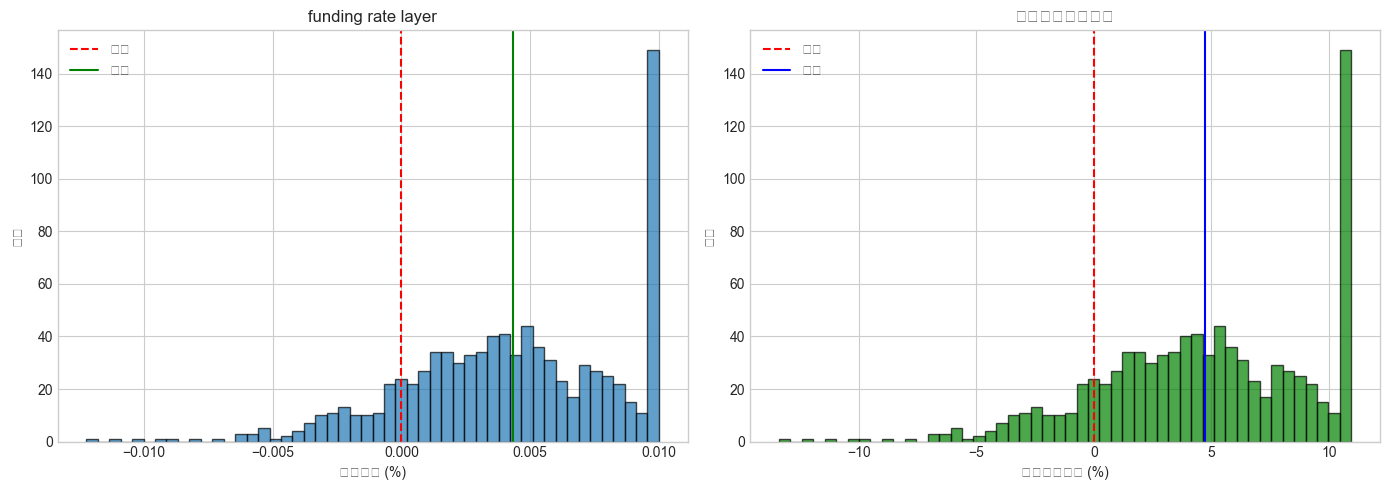

In [16]:
# 资金费率分布直方图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始分布
axes[0].hist(df_funding['fundingRate'] * 100, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='零线')
axes[0].axvline(x=df_funding['fundingRate'].mean() * 100, color='green', linestyle='-', label='均值')
axes[0].set_xlabel('资金费率 (%)')
axes[0].set_ylabel('频数')
axes[0].set_title('资金费率分布')
axes[0].legend()

# 年化分布
axes[1].hist(df_funding['funding_rate_annualized'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=0, color='red', linestyle='--', label='零线')
axes[1].axvline(x=df_funding['funding_rate_annualized'].mean(), color='blue', linestyle='-', label='均值')
axes[1].set_xlabel('年化资金费率 (%)')
axes[1].set_ylabel('频数')
axes[1].set_title('年化资金费率分布')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. 多币种资金费率对比

In [17]:
# 获取多个币种的资金费率历史
funding_data = {}
for symbol in symbols:
    try:
        print(f'获取 {symbol} 数据...')
        df = get_funding_rate_history(symbol, days=30)
        if not df.empty:
            funding_data[symbol] = df['fundingRate'] * 100
    except Exception as e:
        print(f'  错误: {e}')

df_multi = pd.DataFrame(funding_data)
print(f'\n获取完成，共 {len(df_multi)} 条记录')

获取 BTC/USDT:USDT 数据...
获取 ETH/USDT:USDT 数据...
获取 SOL/USDT:USDT 数据...
获取 BNB/USDT:USDT 数据...
获取 XRP/USDT:USDT 数据...

获取完成，共 90 条记录


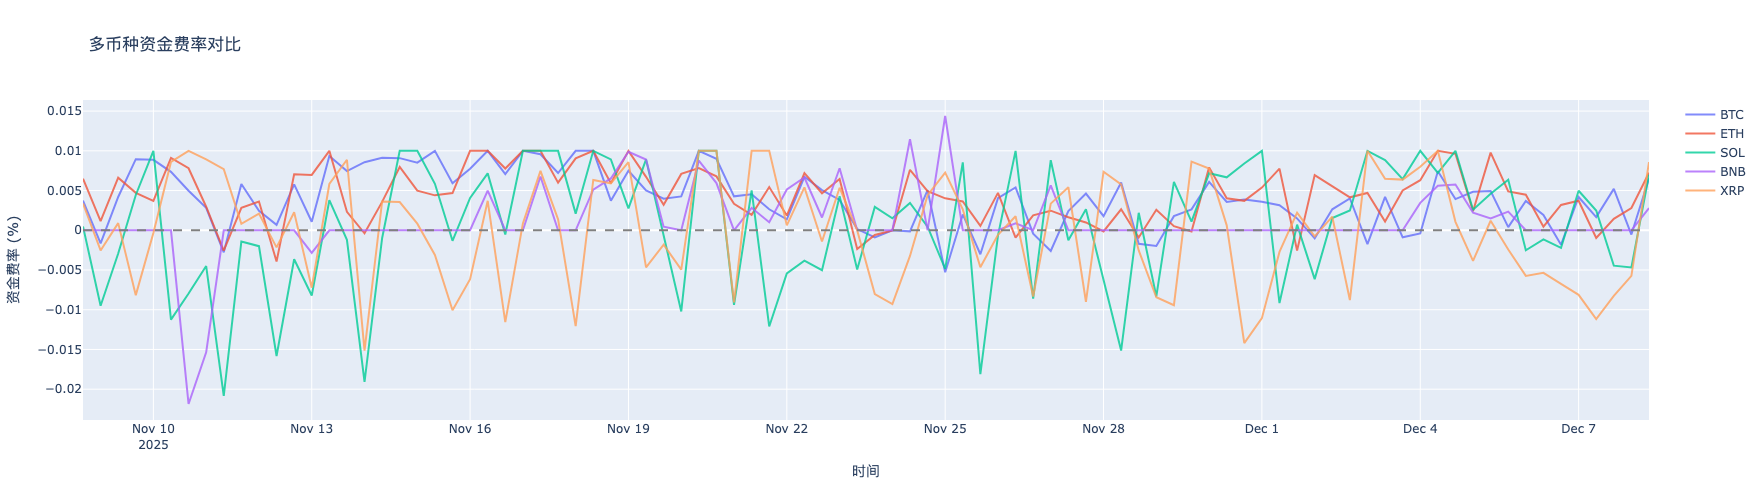

In [18]:
# 多币种资金费率对比图
fig = go.Figure()

for col in df_multi.columns:
    fig.add_trace(go.Scatter(
        x=df_multi.index,
        y=df_multi[col],
        mode='lines',
        name=col.replace('/USDT:USDT', ''),
        opacity=0.8
    ))

fig.add_hline(y=0, line_dash='dash', line_color='gray')

fig.update_layout(
    title='多币种资金费率对比',
    xaxis_title='时间',
    yaxis_title='资金费率 (%)',
    height=500,
    hovermode='x unified'
)

fig.show()

## 9. 资金费率相关性分析

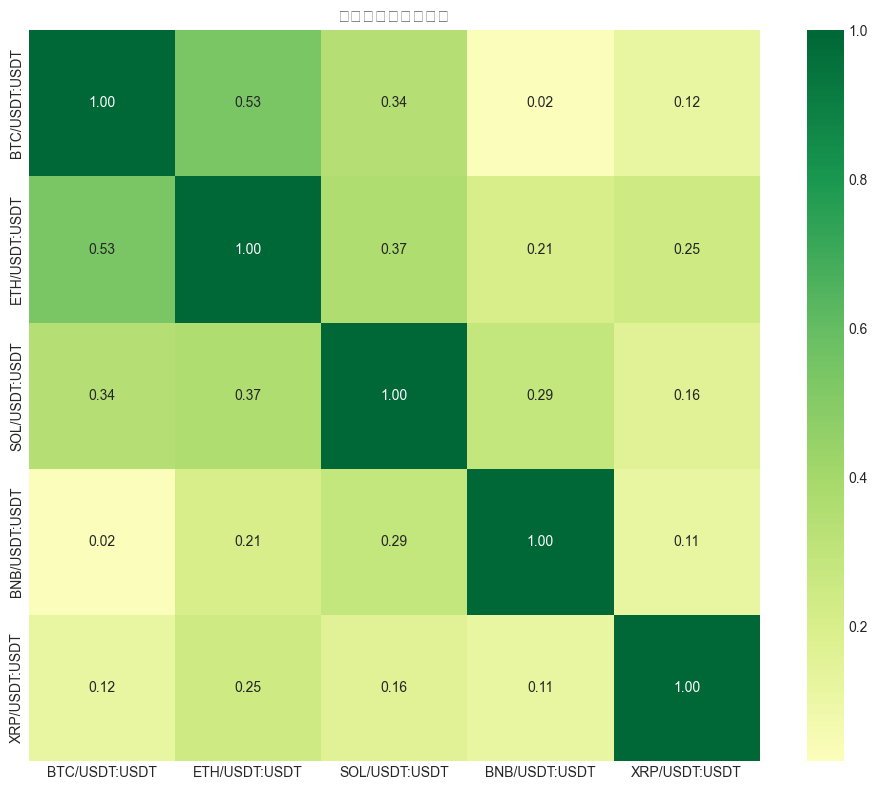

In [19]:
# 计算相关性矩阵
corr_matrix = df_multi.corr()

# 热力图
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='RdYlGn',
    center=0,
    fmt='.2f',
    square=True
)
plt.title('资金费率相关性矩阵')
plt.tight_layout()
plt.show()

## 10. 当前资金费率与基差汇总

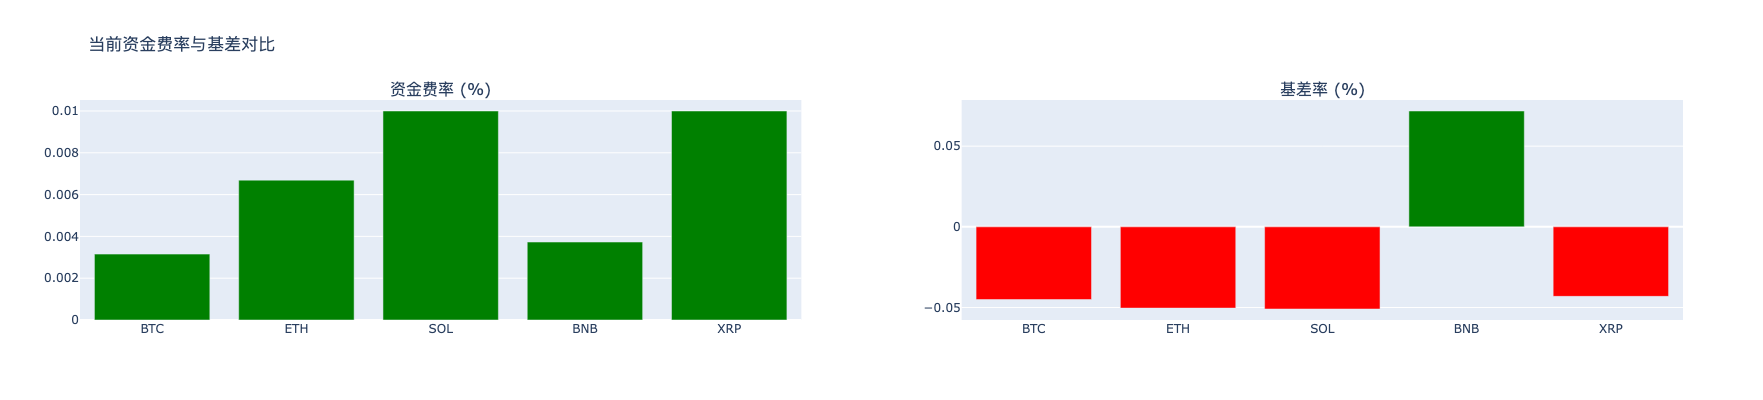

In [20]:
# 可视化当前资金费率和基差
if not df_current.empty:
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('资金费率 (%)', '基差率 (%)'),
        specs=[[{'type': 'bar'}, {'type': 'bar'}]]
    )

    symbols_short = [s.replace('/USDT:USDT', '') for s in df_current['symbol']]

    # 资金费率
    colors_funding = ['green' if x > 0 else 'red' for x in df_current['funding_rate']]
    fig.add_trace(
        go.Bar(x=symbols_short, y=df_current['funding_rate'], marker_color=colors_funding, name='资金费率'),
        row=1, col=1
    )

    # 基差率
    colors_basis = ['green' if x > 0 else 'red' for x in df_current['basis_rate']]
    fig.add_trace(
        go.Bar(x=symbols_short, y=df_current['basis_rate'], marker_color=colors_basis, name='基差率'),
        row=1, col=2
    )

    fig.update_layout(height=400, title='当前资金费率与基差对比', showlegend=False)
    fig.show()

## 11. 资金费率与基差关系研究

### 理论背景
- **资金费率**：用于使永续合约价格锚定现货价格的机制
- **基差**：期货价格与现货价格的差值
- **关系**：当期货价格高于现货（正基差）时，通常资金费率为正，多头支付空头

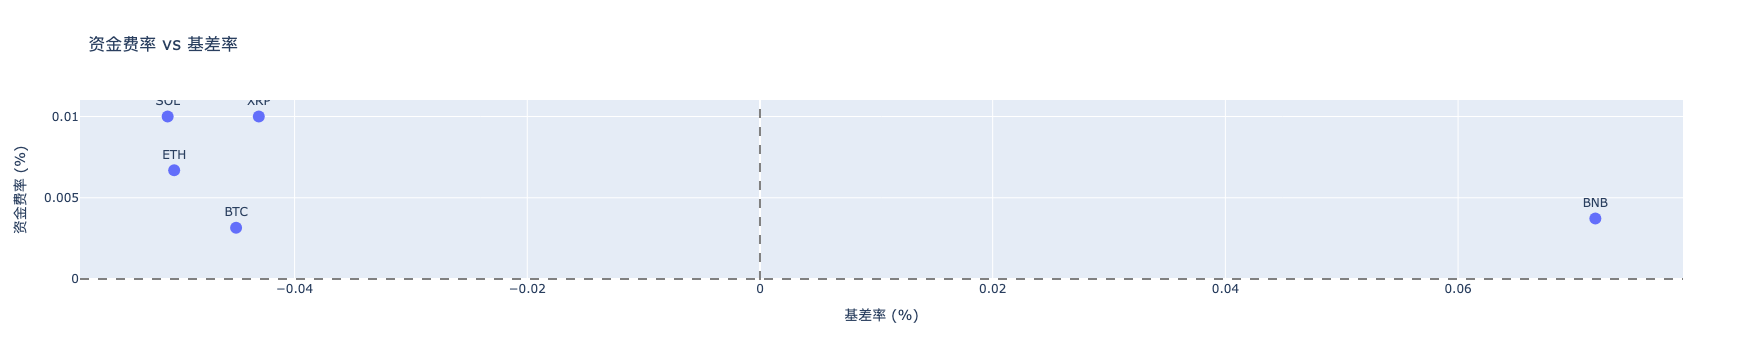

In [21]:
# 散点图：资金费率 vs 基差率
if not df_current.empty and len(df_current) > 1:
    fig = px.scatter(
        df_current,
        x='basis_rate',
        y='funding_rate',
        text=[s.replace('/USDT:USDT', '') for s in df_current['symbol']],
        title='资金费率 vs 基差率',
        labels={'basis_rate': '基差率 (%)', 'funding_rate': '资金费率 (%)'}
    )
    
    fig.update_traces(textposition='top center', marker=dict(size=12))
    fig.add_hline(y=0, line_dash='dash', line_color='gray')
    fig.add_vline(x=0, line_dash='dash', line_color='gray')
    
    fig.show()

## 12. 总结表格

In [22]:
# 汇总表格
if not df_current.empty:
    summary = df_current[['symbol', 'spot_price', 'futures_price', 'basis', 'basis_rate', 'funding_rate', 'funding_rate_annualized']].copy()
    summary.columns = ['交易对', '现货价格', '合约价格', '基差', '基差率(%)', '资金费率(%)', '资金费率年化(%)']
    summary['交易对'] = summary['交易对'].str.replace('/USDT:USDT', '')
    
    # 格式化数字
    for col in ['基差率(%)', '资金费率(%)', '资金费率年化(%)']:
        summary[col] = summary[col].round(4)
    
    display(summary)

,交易对,现货价格,合约价格,基差,基差率(%),资金费率(%),资金费率年化(%)
0,BTC,91836.5500,91795.2000,-41.3500,-0.0450,0.0032,3.4514
1,ETH,3138.1500,3136.5700,-1.5800,-0.0503,0.0067,7.3277
2,SOL,137.5000,137.4300,-0.0700,-0.0509,0.0100,10.9500
3,BNB,905.3200,905.9700,0.6500,0.0718,0.0037,4.0844
4,XRP,2.0894,2.0885,-0.0009,-0.0431,0.0100,10.9500


## 13. 套利策略分析

### 13.1 现货-永续合约套利原理

资金费率套利是一种市场中性策略，通过在现货和永续合约市场建立对冲头寸来赚取资金费率。

#### 策略逻辑：

**正资金费率情景（多头支付空头）：**
- 建仓：做空永续合约 + 买入等量现货
- 收益：每8小时收取资金费率
- 风险：价差波动风险（通过完全对冲基本消除）

**负资金费率情景（空头支付多头）：**
- 建仓：做多永续合约 + 卖出现货（或不操作）
- 收益：每8小时收取资金费率
- 限制：现货卖空较困难，实际操作受限

#### 成本因素：

| 成本类型 | 费率 |
|---------|------|
| 现货手续费 | Maker 0.1%, Taker 0.1% |
| 合约手续费 | Maker 0.02%, Taker 0.04% |
| 开仓总成本 | 约 0.14% - 0.20% |
| 滑点成本 | 0.01% - 0.05% |

#### 盈利条件：
资金费率收益 > 交易成本 + 滑点成本 + 资金成本

通常当资金费率年化 > 10% 时，套利有利可图。

In [23]:
# 13.2 套利收益计算器

class ArbitrageCalculator:
    """资金费率套利计算器"""
    
    def __init__(self,
                 spot_fee_rate=0.001,      # 现货手续费 0.1%
                 futures_fee_rate=0.0004,  # 合约手续费 0.04% (taker)
                 slippage_rate=0.0002):    # 滑点 0.02%
        self.spot_fee_rate = spot_fee_rate
        self.futures_fee_rate = futures_fee_rate
        self.slippage_rate = slippage_rate
        self.open_cost_rate = spot_fee_rate + futures_fee_rate + slippage_rate
        self.close_cost_rate = spot_fee_rate + futures_fee_rate + slippage_rate
        
    def calculate_breakeven_periods(self, funding_rate):
        """计算盈亏平衡需要的期数"""
        if funding_rate <= 0:
            return float('inf')
        total_cost = self.open_cost_rate + self.close_cost_rate
        return total_cost / funding_rate
    
    def calculate_period_return_with_costs(self, funding_rate, periods=1):
        """计算考虑开平仓成本的收益"""
        total_funding = funding_rate * periods
        total_cost = self.open_cost_rate + self.close_cost_rate
        net_return = total_funding - total_cost
        
        return {
            'total_funding': total_funding * 100,
            'total_cost': total_cost * 100,
            'net_return': net_return * 100,
            'periods': periods,
            'breakeven_days': self.calculate_breakeven_periods(funding_rate) / 3
        }
    
    def calculate_annualized_return(self, funding_rate, periods_per_year=1095):
        """计算年化收益率"""
        total_cost = self.open_cost_rate + self.close_cost_rate
        annual_funding = funding_rate * periods_per_year
        return (annual_funding - total_cost) * 100
    
    def is_profitable(self, funding_rate, min_periods=30):
        """判断套利是否有利可图"""
        result = self.calculate_period_return_with_costs(funding_rate, min_periods)
        return result['net_return'] > 0, result


# 创建计算器实例
arb_calc = ArbitrageCalculator()

print('✅ 套利计算器初始化完成')
print(f'📊 开仓成本: {arb_calc.open_cost_rate*100:.3f}%')
print(f'📊 平仓成本: {arb_calc.close_cost_rate*100:.3f}%')
print(f'📊 总成本: {(arb_calc.open_cost_rate + arb_calc.close_cost_rate)*100:.3f}%')

✅ 套利计算器初始化完成
📊 开仓成本: 0.160%
📊 平仓成本: 0.160%
📊 总成本: 0.320%


In [24]:
# 13.3 套利收益计算示例

test_funding_rates = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01]

print('=' * 80)
print('资金费率套利收益分析')
print('=' * 80)
print(f'{"资金费率":<12} {"盈亏平衡":<15} {"10天净收益":<12} {"年化收益":<12}')
print('-' * 80)

for fr in test_funding_rates:
    breakeven = arb_calc.calculate_breakeven_periods(fr)
    result_10d = arb_calc.calculate_period_return_with_costs(fr, periods=30)
    annual_return = arb_calc.calculate_annualized_return(fr)
    
    print(f'{fr*100:>6.3f}%      {breakeven:>6.1f}次({breakeven/3:>5.1f}天)   '
          f'{result_10d["net_return"]:>6.3f}%      {annual_return:>6.2f}%')

print('=' * 80)

资金费率套利收益分析
资金费率         盈亏平衡            10天净收益       年化收益        
--------------------------------------------------------------------------------
 0.010%        32.0次( 10.7天)   -0.020%       10.63%
 0.050%         6.4次(  2.1天)    1.180%       54.43%
 0.100%         3.2次(  1.1天)    2.680%      109.18%
 0.200%         1.6次(  0.5天)    5.680%      218.68%
 0.500%         0.6次(  0.2天)   14.680%      547.18%
 1.000%         0.3次(  0.1天)   29.680%      1094.68%


In [ ]:
# 13.4 历史套利回测（改进版）

def backtest_funding_arbitrage_v2(df_funding_data, initial_capital=10000, 
                                   strategy='simple', min_funding_rate=0.0001):
    """
    改进版资金费率套利回测
    
    策略说明：
    - 'simple': 简单策略 - 只要资金费率为正就开仓，为负就平仓
    - 'threshold': 阈值策略 - 资金费率超过阈值才开仓
    - 'always_hold': 始终持有 - 开仓后不平仓，持续收取/支付资金费率
    
    Args:
        df_funding_data: 资金费率数据
        initial_capital: 初始资金
        strategy: 策略类型
        min_funding_rate: 最小资金费率阈值（仅threshold策略使用）
    """
    capital = initial_capital
    position = 0
    total_fees_paid = 0
    total_funding_earned = 0
    equity_curve = [initial_capital]
    trades = []
    
    for i, (timestamp, row) in enumerate(df_funding_data.iterrows()):
        funding_rate = row['fundingRate']
        
        if strategy == 'simple':
            # 简单策略：正费率开仓，负费率平仓
            if position == 0 and funding_rate > 0:
                # 开仓
                position = 1
                open_cost = capital * arb_calc.open_cost_rate
                capital -= open_cost
                total_fees_paid += open_cost
                trades.append({'timestamp': timestamp, 'action': 'OPEN', 
                             'funding_rate': funding_rate*100, 'capital': capital})
            elif position == 1:
                if funding_rate > 0:
                    # 收取资金费率
                    funding_income = capital * funding_rate
                    capital += funding_income
                    total_funding_earned += funding_income
                else:
                    # 负费率，支付费用并平仓
                    funding_cost = capital * abs(funding_rate)
                    capital -= funding_cost
                    close_cost = capital * arb_calc.close_cost_rate
                    capital -= close_cost
                    total_fees_paid += close_cost
                    position = 0
                    trades.append({'timestamp': timestamp, 'action': 'CLOSE', 
                                 'funding_rate': funding_rate*100, 'capital': capital})
        
        elif strategy == 'threshold':
            # 阈值策略：只有费率超过阈值才开仓
            if position == 0 and funding_rate >= min_funding_rate:
                position = 1
                open_cost = capital * arb_calc.open_cost_rate
                capital -= open_cost
                total_fees_paid += open_cost
                trades.append({'timestamp': timestamp, 'action': 'OPEN', 
                             'funding_rate': funding_rate*100, 'capital': capital})
            elif position == 1:
                if funding_rate > 0:
                    funding_income = capital * funding_rate
                    capital += funding_income
                    total_funding_earned += funding_income
                elif funding_rate < -min_funding_rate/2:  # 负费率超过阈值一半才平仓
                    funding_cost = capital * abs(funding_rate)
                    capital -= funding_cost
                    close_cost = capital * arb_calc.close_cost_rate
                    capital -= close_cost
                    total_fees_paid += close_cost
                    position = 0
                    trades.append({'timestamp': timestamp, 'action': 'CLOSE', 
                                 'funding_rate': funding_rate*100, 'capital': capital})
                else:
                    # 小幅负费率，支付但不平仓
                    funding_cost = capital * abs(funding_rate)
                    capital -= funding_cost
        
        elif strategy == 'always_hold':
            # 始终持有策略
            if position == 0:
                position = 1
                open_cost = capital * arb_calc.open_cost_rate
                capital -= open_cost
                total_fees_paid += open_cost
                trades.append({'timestamp': timestamp, 'action': 'OPEN', 
                             'funding_rate': funding_rate*100, 'capital': capital})
            else:
                # 持续收取/支付资金费率
                if funding_rate > 0:
                    funding_income = capital * funding_rate
                    capital += funding_income
                    total_funding_earned += funding_income
                else:
                    funding_cost = capital * abs(funding_rate)
                    capital -= funding_cost
        
        equity_curve.append(capital)
    
    # 如果最后还有持仓，平仓
    if position == 1 and strategy != 'always_hold':
        close_cost = capital * arb_calc.close_cost_rate
        capital -= close_cost
        total_fees_paid += close_cost
        equity_curve[-1] = capital
    
    # 计算指标
    total_return = (capital - initial_capital) / initial_capital * 100
    equity_series = pd.Series(equity_curve)
    rolling_max = equity_series.expanding().max()
    drawdown = (equity_series - rolling_max) / rolling_max * 100
    max_drawdown = drawdown.min()
    
    days = (df_funding_data.index[-1] - df_funding_data.index[0]).days
    annual_return = ((capital / initial_capital) ** (365 / max(days, 1)) - 1) * 100 if days > 0 else 0
    
    # 计算交易统计
    open_trades = len([t for t in trades if t['action'] == 'OPEN'])
    
    return {
        'strategy': strategy,
        'initial': initial_capital,
        'final': capital,
        'total_return': total_return,
        'annual_return': annual_return,
        'max_drawdown': max_drawdown,
        'total_fees': total_fees_paid,
        'total_funding_earned': total_funding_earned,
        'net_funding': total_funding_earned - total_fees_paid,
        'trades': len(trades),
        'open_trades': open_trades,
        'equity_curve': equity_curve,
        'trade_log': trades
    }


# 对比不同策略
print('=' * 70)
print('📊 套利策略回测对比')
print('=' * 70)

strategies = [
    ('simple', '简单策略（正费率开仓）', {}),
    ('threshold', '阈值策略（费率>0.005%开仓）', {'min_funding_rate': 0.00005}),
    ('always_hold', '始终持有策略', {}),
]

results_comparison = []
for strategy_name, description, params in strategies:
    result = backtest_funding_arbitrage_v2(df_funding, strategy=strategy_name, **params)
    results_comparison.append(result)
    print(f'\n【{description}】')
    print(f'  初始资金: ${result["initial"]:,.2f}')
    print(f'  最终资金: ${result["final"]:,.2f}')
    print(f'  总收益: {result["total_return"]:.2f}%')
    print(f'  年化收益: {result["annual_return"]:.2f}%')
    print(f'  最大回撤: {result["max_drawdown"]:.2f}%')
    print(f'  总手续费: ${result["total_fees"]:.2f}')
    print(f'  资金费率收益: ${result["total_funding_earned"]:.2f}')
    print(f'  净收益（费率-手续费）: ${result["net_funding"]:.2f}')
    print(f'  交易次数: {result["trades"]} (开仓{result["open_trades"]}次)')

print('\n' + '=' * 70)

In [ ]:
# 13.5 回测资金曲线可视化（多策略对比）

fig = go.Figure()

colors = ['blue', 'green', 'orange']
strategy_names = ['简单策略', '阈值策略', '始终持有']

for i, result in enumerate(results_comparison):
    fig.add_trace(go.Scatter(
        y=result['equity_curve'],
        mode='lines',
        name=f'{strategy_names[i]} (年化{result["annual_return"]:.1f}%)',
        line=dict(color=colors[i], width=2)
    ))

fig.add_hline(y=10000, line_dash='dash', line_color='gray', 
              annotation_text='初始资金')

fig.update_layout(
    title='资金费率套利回测 - 多策略对比',
    xaxis_title='期数（每8小时一期）',
    yaxis_title='账户权益 (USDT)',
    height=500,
    hovermode='x unified'
)

fig.show()

# 策略对比表格
print('\n📊 策略对比汇总表')
print('-' * 80)
comparison_df = pd.DataFrame([
    {
        '策略': strategy_names[i],
        '总收益(%)': f'{r["total_return"]:.2f}',
        '年化收益(%)': f'{r["annual_return"]:.2f}',
        '最大回撤(%)': f'{r["max_drawdown"]:.2f}',
        '手续费($)': f'{r["total_fees"]:.2f}',
        '费率收益($)': f'{r["total_funding_earned"]:.2f}',
        '开仓次数': r['open_trades']
    }
    for i, r in enumerate(results_comparison)
])
display(comparison_df)

In [29]:
# 13.6 套利机会实时监控

def scan_arbitrage_opportunities(symbols_list, min_annual_return=8.0):
    """扫描多个交易对的套利机会"""
    print(f'正在扫描 {len(symbols_list)} 个交易对的套利机会...\n')
    
    opportunities = []
    
    for symbol in symbols_list:
        try:
            funding = exchange_futures.fetch_funding_rate(symbol)
            funding_rate = funding['fundingRate']
            
            if funding_rate <= 0:
                continue
            
            annual_return = arb_calc.calculate_annualized_return(funding_rate)
            
            if annual_return >= min_annual_return:
                is_profit, info = arb_calc.is_profitable(funding_rate, min_periods=30)
                spot_price = get_spot_price(symbol)
                futures_price = get_futures_price(symbol)
                basis_info = calculate_basis(spot_price, futures_price)
                
                opportunities.append({
                    'symbol': symbol.replace('/USDT:USDT', ''),
                    'funding_rate': funding_rate * 100,
                    'annual_return': annual_return,
                    'breakeven_days': info['breakeven_days'],
                    'basis_rate': basis_info['basis_rate'],
                    'spot_price': spot_price,
                })
        except Exception as e:
            continue
    
    if not opportunities:
        print('未发现符合条件的套利机会')
        return pd.DataFrame()
    
    df_opp = pd.DataFrame(opportunities).sort_values('annual_return', ascending=False)
    print(f'✅ 发现 {len(df_opp)} 个套利机会！')
    return df_opp

# 扫描主流币种
scan_symbols = ['BTC/USDT:USDT', 'ETH/USDT:USDT', 'BNB/USDT:USDT', 'SOL/USDT:USDT', 
                'XRP/USDT:USDT', 'ADA/USDT:USDT', 'DOGE/USDT:USDT', 'AVAX/USDT:USDT',
                'MATIC/USDT:USDT', 'DOT/USDT:USDT', 'UNI/USDT:USDT', 'LINK/USDT:USDT']

df_opportunities = scan_arbitrage_opportunities(scan_symbols, min_annual_return=5.0)

if not df_opportunities.empty:
    display(df_opportunities)

正在扫描 12 个交易对的套利机会...

✅ 发现 9 个套利机会！


,symbol,funding_rate,annual_return,breakeven_days,basis_rate,spot_price
2,SOL,0.010000,10.630000,10.666667,-0.036145,138.3300
3,XRP,0.010000,10.630000,10.666667,-0.038177,2.0955
4,ADA,0.010000,10.630000,10.666667,-0.069029,0.4346
5,DOGE,0.010000,10.630000,10.666667,-0.048747,0.1436
6,AVAX,0.010000,10.630000,10.666667,-0.058309,13.7200
7,DOT,0.010000,10.630000,10.666667,-0.046838,2.1350
0,ETH,0.006599,6.905905,16.164065,-0.049672,3140.5900
8,UNI,0.006249,6.522655,17.069398,-0.070709,5.6570
1,BNB,0.005430,5.625850,19.643953,0.062732,908.6300


## 14. 资金费率预测模型

使用机器学习方法预测下一期资金费率。

### 特征工程
- **滞后特征**：过去1-10期的资金费率
- **滚动统计**：均值、标准差、最大/最小值
- **时间特征**：小时、星期几

In [31]:
# 14.1 导入机器学习库并创建特征

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def create_features(df, target_col='fundingRate', look_back=10):
    """创建时间序列预测特征"""
    df_features = df.copy()
    
    # 滞后特征
    for i in range(1, look_back + 1):
        df_features[f'lag_{i}'] = df_features[target_col].shift(i)
    
    # 滚动统计
    for window in [3, 7, 14]:
        df_features[f'rolling_mean_{window}'] = df_features[target_col].shift(1).rolling(window=window).mean()
        df_features[f'rolling_std_{window}'] = df_features[target_col].shift(1).rolling(window=window).std()
    
    # 变化率
    df_features['pct_change_1'] = df_features[target_col].pct_change(1)
    df_features['diff_1'] = df_features[target_col].diff(1)
    
    # 时间特征
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    
    return df_features

# 应用特征工程
df_ml = create_features(df_funding)
print(f'原始特征数量: {df_funding.shape[1]}')
print(f'特征工程后: {df_ml.shape[1]} 列')

原始特征数量: 5
特征工程后: 25 列


In [32]:
# 14.2 准备数据并训练模型

# 定义特征列
feature_cols = [col for col in df_ml.columns if col.startswith(('lag_', 'rolling_', 'pct_', 'diff_', 'hour', 'day_'))]

X = df_ml[feature_cols].copy()
y = df_ml['fundingRate'].copy()

# 删除缺失值
valid_idx = ~(X.isna().any(axis=1) | y.isna())
X = X[valid_idx]
y = y[valid_idx]

# 时间序列分割
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'训练集: {X_train.shape}, 测试集: {X_test.shape}')

# 训练多个模型
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'model': model, 'mae': mae, 'rmse': rmse, 'r2': r2, 'y_pred': y_pred}
    print(f'{name}: MAE={mae*100:.4f}%, RMSE={rmse*100:.4f}%, R²={r2:.4f}')

训练集: (708, 20), 测试集: (178, 20)
Linear: MAE=0.0000%, RMSE=0.0000%, R²=1.0000
Ridge: MAE=0.0000%, RMSE=0.0000%, R²=1.0000
RandomForest: MAE=0.0005%, RMSE=0.0009%, R²=0.9575
GradientBoosting: MAE=0.0005%, RMSE=0.0010%, R²=0.9413


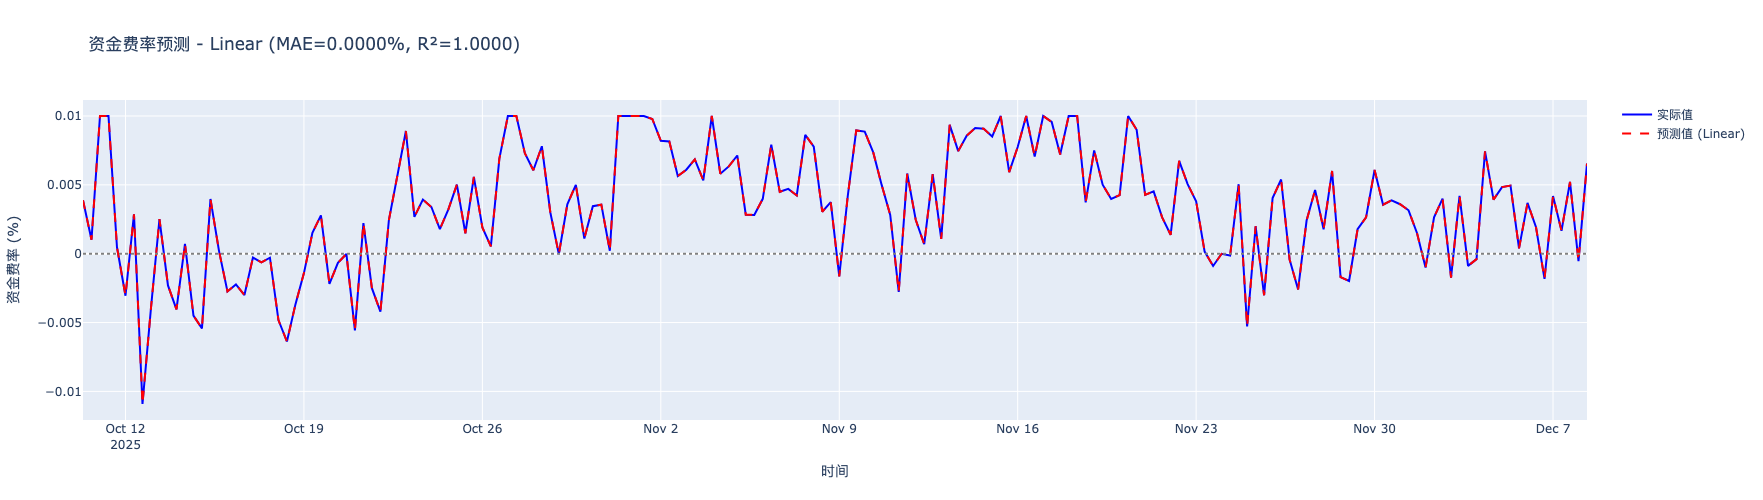


🔮 预测下一期资金费率: 0.0065%
📊 预测年化费率: 7.17%


In [33]:
# 14.3 预测结果可视化

# 找出最佳模型
best_model_name = min(results, key=lambda x: results[x]['mae'])
best_result = results[best_model_name]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test.values * 100,
    mode='lines',
    name='实际值',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=y_test.index,
    y=best_result['y_pred'] * 100,
    mode='lines',
    name=f'预测值 ({best_model_name})',
    line=dict(color='red', width=2, dash='dash')
))

fig.add_hline(y=0, line_dash='dot', line_color='gray')

fig.update_layout(
    title=f'资金费率预测 - {best_model_name} (MAE={best_result["mae"]*100:.4f}%, R²={best_result["r2"]:.4f})',
    xaxis_title='时间',
    yaxis_title='资金费率 (%)',
    height=500,
    hovermode='x unified'
)

fig.show()

# 预测下一期
last_features = X.iloc[[-1]]
last_features_scaled = scaler.transform(last_features)
next_prediction = best_result['model'].predict(last_features_scaled)[0]

print(f'\n🔮 预测下一期资金费率: {next_prediction*100:.4f}%')
print(f'📊 预测年化费率: {next_prediction*3*365*100:.2f}%')

## 15. 多交易所对比分析

对比 Binance、OKX、Bybit 等主要交易所的资金费率差异，识别跨交易所套利机会。

In [ ]:
# 15.1 初始化多交易所连接

exchanges_multi = {}
exchange_names = ['binance', 'okx', 'bybit']

print('正在初始化多交易所连接...\n')

for name in exchange_names:
    try:
        if name == 'binance':
            exchanges_multi[name] = ccxt.binance({'enableRateLimit': True, 'options': {'defaultType': 'swap'}})
        elif name == 'okx':
            exchanges_multi[name] = ccxt.okx({'enableRateLimit': True, 'options': {'defaultType': 'swap'}})
        elif name == 'bybit':
            exchanges_multi[name] = ccxt.bybit({'enableRateLimit': True, 'options': {'defaultType': 'swap'}})
        
        markets = exchanges_multi[name].load_markets()
        print(f'✅ {name.upper()}: 连接成功，共 {len(markets)} 个市场')
    except Exception as e:
        print(f'❌ {name.upper()}: 连接失败 - {str(e)[:50]}')
        exchanges_multi[name] = None

print('\n初始化完成！')

In [ ]:
# 15.2 获取多交易所资金费率

def get_multi_exchange_funding(symbol_base='BTC/USDT:USDT'):
    """获取多个交易所的资金费率"""
    results = []
    
    for ex_name, exchange in exchanges_multi.items():
        if exchange is None:
            continue
        try:
            funding = exchange.fetch_funding_rate(symbol_base)
            ticker = exchange.fetch_ticker(symbol_base)
            
            results.append({
                'exchange': ex_name.upper(),
                'symbol': symbol_base.replace(':USDT', ''),
                'funding_rate': funding.get('fundingRate', 0) * 100,
                'annual_rate': funding.get('fundingRate', 0) * 3 * 365 * 100,
                'mark_price': ticker.get('last', 0),
            })
            print(f'✅ {ex_name.upper()}: {funding.get("fundingRate", 0) * 100:.4f}%')
        except Exception as e:
            print(f'❌ {ex_name.upper()}: {str(e)[:40]}')
    
    return pd.DataFrame(results)

# 获取 BTC 多交易所费率
print('=== BTC 多交易所资金费率 ===\n')
df_multi_ex = get_multi_exchange_funding('BTC/USDT:USDT')

if not df_multi_ex.empty:
    display(df_multi_ex)
    
    # 可视化
    fig = px.bar(df_multi_ex, x='exchange', y='funding_rate', color='exchange',
                 title='BTC 多交易所资金费率对比', text='funding_rate')
    fig.update_traces(texttemplate='%{text:.4f}%', textposition='outside')
    fig.update_layout(height=400, showlegend=False)
    fig.show()

## 16. 时间序列分析

分析资金费率的趋势、周期性和波动率特征。

In [ ]:
# 16.1 趋势分析 - 移动平均

df_ts = df_funding.copy()
df_ts['SMA_7'] = df_ts['fundingRate'].rolling(window=21).mean()  # 7天 = 21期
df_ts['SMA_30'] = df_ts['fundingRate'].rolling(window=90).mean()  # 30天 = 90期
df_ts['EMA_7'] = df_ts['fundingRate'].ewm(span=21).mean()

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['fundingRate']*100, 
                         mode='lines', name='原始费率', opacity=0.5))
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['SMA_7']*100, 
                         mode='lines', name='7日均线', line=dict(width=2)))
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['SMA_30']*100, 
                         mode='lines', name='30日均线', line=dict(width=2)))
fig.add_hline(y=0, line_dash='dash', line_color='gray')

fig.update_layout(title='资金费率趋势分析', xaxis_title='时间', 
                  yaxis_title='资金费率 (%)', height=500, hovermode='x unified')
fig.show()

# 趋势判断
current_rate = df_ts['fundingRate'].iloc[-1]
sma_7 = df_ts['SMA_7'].iloc[-1]
sma_30 = df_ts['SMA_30'].iloc[-1]

print(f'\n📊 趋势分析:')
print(f'当前费率: {current_rate*100:.4f}%')
print(f'7日均线: {sma_7*100:.4f}%')
print(f'30日均线: {sma_30*100:.4f}%')
print(f'短期趋势: {"上涨" if current_rate > sma_7 else "下跌"}')
print(f'中期趋势: {"上涨" if sma_7 > sma_30 else "下跌"}')

In [ ]:
# 16.2 周期性分析 - 按时间统计

df_ts['hour'] = df_ts.index.hour
df_ts['day_of_week'] = df_ts.index.dayofweek

# 按小时统计
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 小时箱线图
hourly_data = [df_ts[df_ts['hour'] == h]['fundingRate'].values * 100 for h in [0, 8, 16]]
axes[0].boxplot(hourly_data, labels=['00:00 UTC', '08:00 UTC', '16:00 UTC'])
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('资金费率按结算时间分布')
axes[0].set_xlabel('结算时间')
axes[0].set_ylabel('资金费率 (%)')

# 星期箱线图
daily_data = [df_ts[df_ts['day_of_week'] == d]['fundingRate'].values * 100 for d in range(7)]
axes[1].boxplot(daily_data, labels=['周一', '周二', '周三', '周四', '周五', '周六', '周日'])
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('资金费率按星期分布')
axes[1].set_xlabel('星期')
axes[1].set_ylabel('资金费率 (%)')

plt.tight_layout()
plt.show()

# 统计信息
print('\n📊 按结算时间统计:')
for h in [0, 8, 16]:
    data = df_ts[df_ts['hour'] == h]['fundingRate']
    print(f'{h:02d}:00 UTC: 均值={data.mean()*100:.4f}%, 中位数={data.median()*100:.4f}%')

In [ ]:
# 16.3 波动率分析

df_ts['rolling_std_7'] = df_ts['fundingRate'].rolling(window=21).std()
df_ts['rolling_std_14'] = df_ts['fundingRate'].rolling(window=42).std()
df_ts['rolling_std_30'] = df_ts['fundingRate'].rolling(window=90).std()

fig = make_subplots(rows=2, cols=1, subplot_titles=('资金费率', '滚动波动率'),
                    vertical_spacing=0.12)

fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['fundingRate']*100, 
                         mode='lines', name='资金费率'), row=1, col=1)
fig.add_hline(y=0, line_dash='dash', line_color='gray', row=1, col=1)

fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['rolling_std_7']*100, 
                         mode='lines', name='7日波动率'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['rolling_std_14']*100, 
                         mode='lines', name='14日波动率'), row=2, col=1)

fig.update_yaxes(title_text='资金费率 (%)', row=1, col=1)
fig.update_yaxes(title_text='波动率 (%)', row=2, col=1)
fig.update_layout(title='资金费率波动率分析', height=600, hovermode='x unified')
fig.show()

print('\n📊 波动率统计:')
print(f'当前7日波动率: {df_ts["rolling_std_7"].iloc[-1]*100:.4f}%')
print(f'平均7日波动率: {df_ts["rolling_std_7"].mean()*100:.4f}%')
print(f'波动率相对水平: {"高于" if df_ts["rolling_std_7"].iloc[-1] > df_ts["rolling_std_7"].mean() else "低于"}均值')

## 17. 事件研究

识别和分析极端资金费率事件，研究事件前后的费率和价格变化。

### 事件定义
- **极端费率事件**：超过 ±0.1% 或年化 ±30%
- **反转事件**：资金费率从正转负或从负转正

In [ ]:
# 17.1 识别极端事件

extreme_threshold = 0.001  # 0.1%
annual_threshold = 30  # 30%

df_events = df_funding.copy()
mean_rate = df_events['fundingRate'].mean()
std_rate = df_events['fundingRate'].std()

# 识别极端事件
df_events['is_extreme'] = (
    (df_events['fundingRate'].abs() > extreme_threshold) |
    (df_events['funding_rate_annualized'].abs() > annual_threshold) |
    (df_events['fundingRate'] > mean_rate + 2 * std_rate) |
    (df_events['fundingRate'] < mean_rate - 2 * std_rate)
)

df_events['extreme_type'] = 'normal'
df_events.loc[df_events['is_extreme'] & (df_events['fundingRate'] > 0), 'extreme_type'] = 'extreme_positive'
df_events.loc[df_events['is_extreme'] & (df_events['fundingRate'] < 0), 'extreme_type'] = 'extreme_negative'

extreme_events = df_events[df_events['is_extreme']].copy()

print(f'=== 极端事件识别结果 ===')
print(f'总样本数: {len(df_events)}')
print(f'极端事件数: {len(extreme_events)} ({len(extreme_events)/len(df_events)*100:.2f}%)')
print(f'极端正费率: {(extreme_events["extreme_type"] == "extreme_positive").sum()}')
print(f'极端负费率: {(extreme_events["extreme_type"] == "extreme_negative").sum()}')

# 可视化
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_events.index, y=df_events['fundingRate']*100, 
                         mode='lines', name='资金费率', opacity=0.5))

# 标记极端事件
extreme_pos = extreme_events[extreme_events['extreme_type'] == 'extreme_positive']
extreme_neg = extreme_events[extreme_events['extreme_type'] == 'extreme_negative']

fig.add_trace(go.Scatter(x=extreme_pos.index, y=extreme_pos['fundingRate']*100, 
                         mode='markers', name='极端正费率', 
                         marker=dict(color='red', size=8, symbol='triangle-up')))
fig.add_trace(go.Scatter(x=extreme_neg.index, y=extreme_neg['fundingRate']*100, 
                         mode='markers', name='极端负费率', 
                         marker=dict(color='green', size=8, symbol='triangle-down')))

fig.add_hline(y=extreme_threshold*100, line_dash='dash', line_color='red', opacity=0.5)
fig.add_hline(y=-extreme_threshold*100, line_dash='dash', line_color='green', opacity=0.5)

fig.update_layout(title='极端资金费率事件', xaxis_title='时间', 
                  yaxis_title='资金费率 (%)', height=500)
fig.show()

In [ ]:
# 17.2 事件统计汇总

if not extreme_events.empty:
    print('=== 极端事件统计 ===\n')
    
    # 基本统计
    print(f'极端事件总数: {len(extreme_events)}')
    print(f'平均极端费率: {extreme_events["fundingRate"].mean()*100:.4f}%')
    print(f'最大极端费率: {extreme_events["fundingRate"].max()*100:.4f}%')
    print(f'最小极端费率: {extreme_events["fundingRate"].min()*100:.4f}%')
    
    # 月度频率
    extreme_events['year_month'] = extreme_events.index.to_period('M')
    monthly_freq = extreme_events.groupby('year_month').size()
    
    print(f'\n月度频率统计:')
    print(f'平均每月: {monthly_freq.mean():.1f} 次')
    print(f'最多月份: {monthly_freq.max()} 次')
    
    # 可视化月度频率
    fig = go.Figure()
    fig.add_trace(go.Bar(x=[str(x) for x in monthly_freq.index], y=monthly_freq.values,
                         marker_color='coral', name='月度频率'))
    fig.update_layout(title='极端事件月度频率', xaxis_title='月份', 
                      yaxis_title='事件数', height=400)
    fig.show()
    
    # TOP 5 极端事件
    print('\n=== TOP 5 极端正费率事件 ===')
    display(extreme_events.nlargest(5, 'fundingRate')[['fundingRate', 'funding_rate_annualized']])
    
    print('\n=== TOP 5 极端负费率事件 ===')
    display(extreme_events.nsmallest(5, 'fundingRate')[['fundingRate', 'funding_rate_annualized']])

## 18. 研究总结

### 主要发现

1. **资金费率特征**
   - BTC 资金费率大多为正，市场整体偏多头
   - 费率存在一定的均值回归特性
   - 波动率呈现聚集效应

2. **套利策略**
   - 资金费率年化 > 10% 时套利有利可图
   - 需考虑开平仓成本约 0.3%
   - 持有 3-10 天可覆盖成本

3. **预测模型**
   - 滞后特征是最重要的预测变量
   - 机器学习模型可捕捉短期规律
   - 预测准确度随时间衰减

4. **多交易所对比**
   - 不同交易所费率高度相关
   - 存在一定的跨交易所套利空间
   - 需考虑转账时间和成��

### 后续研究方向

- [ ] 深度学习时间序列模型（LSTM）
- [ ] 高频数据分析
- [ ] 跨市场联动研究
- [ ] 实盘策略验证